In [60]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from math import sqrt
from matplotlib import pyplot
from matplotlib import pyplot as plt

/home/abhiraj/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def rmse(test, pred):
  return sqrt(mean_squared_error(test, pred))

In [3]:
series = pd.Series.from_csv('../datasets/perrin-freres-monthly-champagne.csv',header=0)

In [4]:
series.head()

Month
1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
Name: Perrin Freres monthly champagne sales millions, dtype: int64

## Defining validation dataset
The dataset ranges from date 1964-01 to 1972-09. Lets keep the past one year of data as our validation dataset i.e 1971-09 to 1972-09.

In [5]:
splitpoint = len(series) - 12
dataset, validation = series[0:splitpoint], series[splitpoint:]
print('Length of dataset: {} and validation set: {}'.format(len(dataset),len(validation)))

Length of dataset: 93 and validation set: 12


# TRAINING

In [6]:
#We only deal with dataset here. Ignore the validation set
series = dataset

## Defining Performance Measure and Test Strategy

For performance evaluation we'll use RMSE because it gives higher penalty. Any transformations to the data must be reversed brfore applying RMSE

For testing strategy, well use walk forward validation. Because we need `Rolling forcast` type model.
- The first 50% of the dataset will be held back to train the model.
- The remaining 50% of the dataset will be iterated and test the model.
- For each step in the test dataset:
    - A model will be trained.
    - A one-step prediction made and the prediction stored for later evaluation.
    - The actual observation from the test dataset will be added to the training dataset for the next iteration.
- The predictions made during the iteration of the test dataset will be evaluated and an RMSE score reported.
- Given the small size of the data, we will allow a model to be re-trained given all available data prior to each prediction.

### Baseline model
The baseline prediction for time series forecasting is called the naive forecast, or persistence. This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

    i.e `Observation(t) = Observation(t-1)` 

In [61]:
X = series.values
X = X.astype('float32')

#Data prep
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

#walk-forward validation
history = [x for x in train]
predictions = list()

for i in range(len(test)):
  #predict
  yt_next = history[-1]
  predictions.append(yt_next)
  #observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yt_next, obs))
  
#Report performance
error = rmse(test, predictions)
print('RMSE: %.3f' % error)

>Predicted=5428.000, Expected=8314.000
>Predicted=8314.000, Expected=10651.000
>Predicted=10651.000, Expected=3633.000
>Predicted=3633.000, Expected=4292.000
>Predicted=4292.000, Expected=4154.000
>Predicted=4154.000, Expected=4121.000
>Predicted=4121.000, Expected=4647.000
>Predicted=4647.000, Expected=4753.000
>Predicted=4753.000, Expected=3965.000
>Predicted=3965.000, Expected=1723.000
>Predicted=1723.000, Expected=5048.000
>Predicted=5048.000, Expected=6922.000
>Predicted=6922.000, Expected=9858.000
>Predicted=9858.000, Expected=11331.000
>Predicted=11331.000, Expected=4016.000
>Predicted=4016.000, Expected=3957.000
>Predicted=3957.000, Expected=4510.000
>Predicted=4510.000, Expected=4276.000
>Predicted=4276.000, Expected=4968.000
>Predicted=4968.000, Expected=4677.000
>Predicted=4677.000, Expected=3523.000
>Predicted=3523.000, Expected=1821.000
>Predicted=1821.000, Expected=5222.000
>Predicted=5222.000, Expected=6872.000
>Predicted=6872.000, Expected=10803.000
>Predicted=10803.000

## Analysis
Now that we have a baseline model setup, we have an idea of what to do with our data, lets delve deeper into out data and see whats happening under the hood.
We'll look at:
- Summary Stats
- Line Plot
- Seasonal Line Plot
- Density Plot
- Box and Whisker Plot


In [8]:
print(series.describe())

count       93.000000
mean      4641.118280
std       2486.403841
min       1573.000000
25%       3036.000000
50%       4016.000000
75%       5048.000000
max      13916.000000
Name: Perrin Freres monthly champagne sales millions, dtype: float64


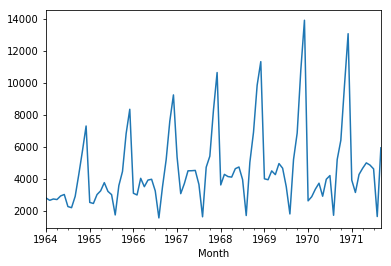

In [9]:
series.plot()
plt.show()

Some observations from the line plot:

- There may be an increasing trend of sales over time.
- There appears to be systematic seasonality to the sales for each year.
- The seasonal signal appears to be growing over time, suggesting a multiplicative relationship (increasing change).
- There do not appear to be any obvious outliers.
- The seasonality suggests that the series is almost certainly non-stationary.

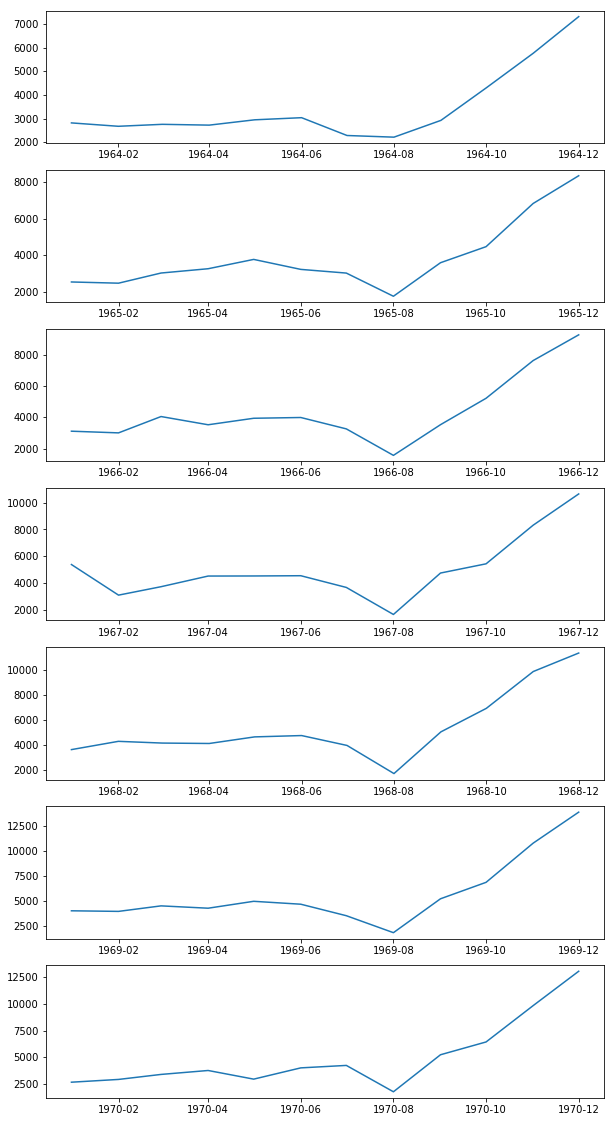

In [45]:
groups = series['1964':'1970'].groupby(pd.TimeGrouper('A'))
plt.figure(figsize = [10,20])
i=1
n_groups = len(groups)
for name, group in groups:
  plt.subplot((n_groups*100) + 10 +    i)
  # subplot:         row      col   plt_number
  i += 1
  plt.plot(group)
  
plt.show()

#### Line Plot
Theres dip every august & rise every Aug-Dec

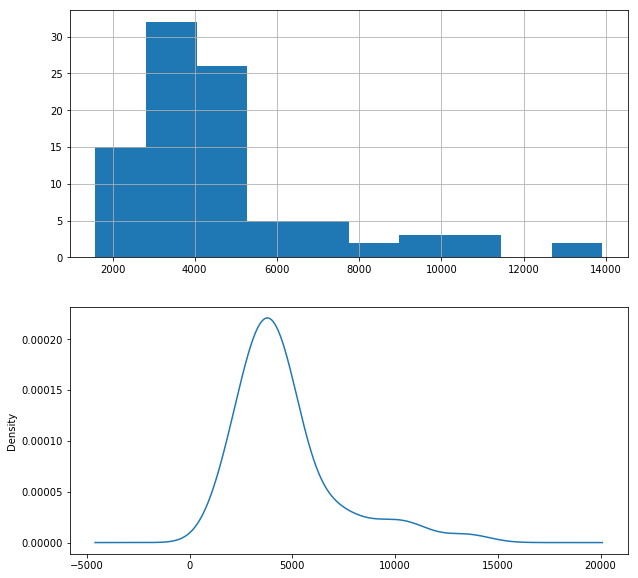

In [47]:
pyplot.figure(figsize = [10,10])
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

#### Density plot
- The distrubution has long tail and suggests some amount of exp distrubution
- Looking at this well explore some power transforms of data prior to modelling

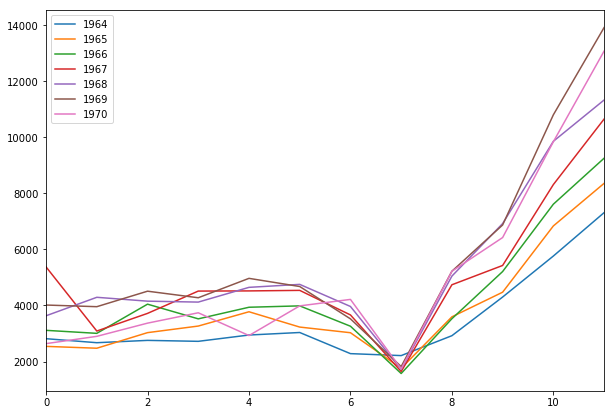

In [57]:
years = pd.DataFrame()

for name, group in groups:
  years[name.year] = group.values

years.plot(figsize = [10,7])
plt.show()

#### Distrubution plot
- Its clear from the increase in slopes that the acceleration of sale between Aug-dec increases year by year.
- The dip comes down to almost equal value in Aug every year

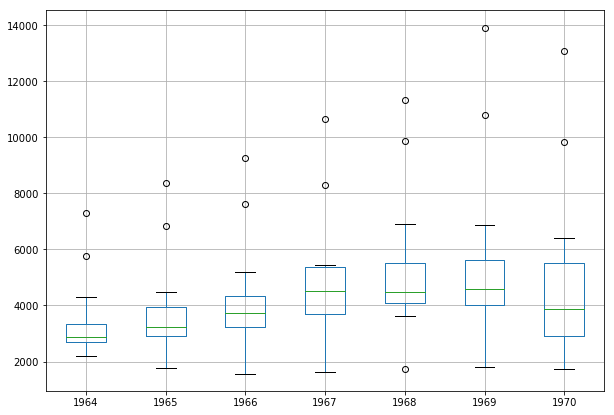

In [58]:
plt.figure(figsize = [10,7])
years.boxplot()
plt.show()

####  Box and whiskers Plot
- The last year 1970 looks different from the tren in the prior years.
- The median shows increasing trend
- The spred appears reasonably stable
- There are outliers each year; these may be the tops or bottoms of seasonal cycle

## Autoregressive Integrated Moving Average, or ARIMA model


ADF Statistic: -7.134898
p-value: 0.000000
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586


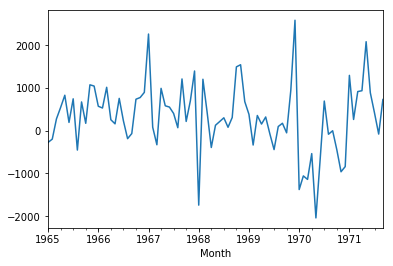

In [64]:
#Manually configured
#Create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return pd.Series(diff)

# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

# plot
stationary.plot()
pyplot.show()